### Adaptive RAG
Query Analysis + Self RAG (Generation Analysis + Post Generation Analysis)
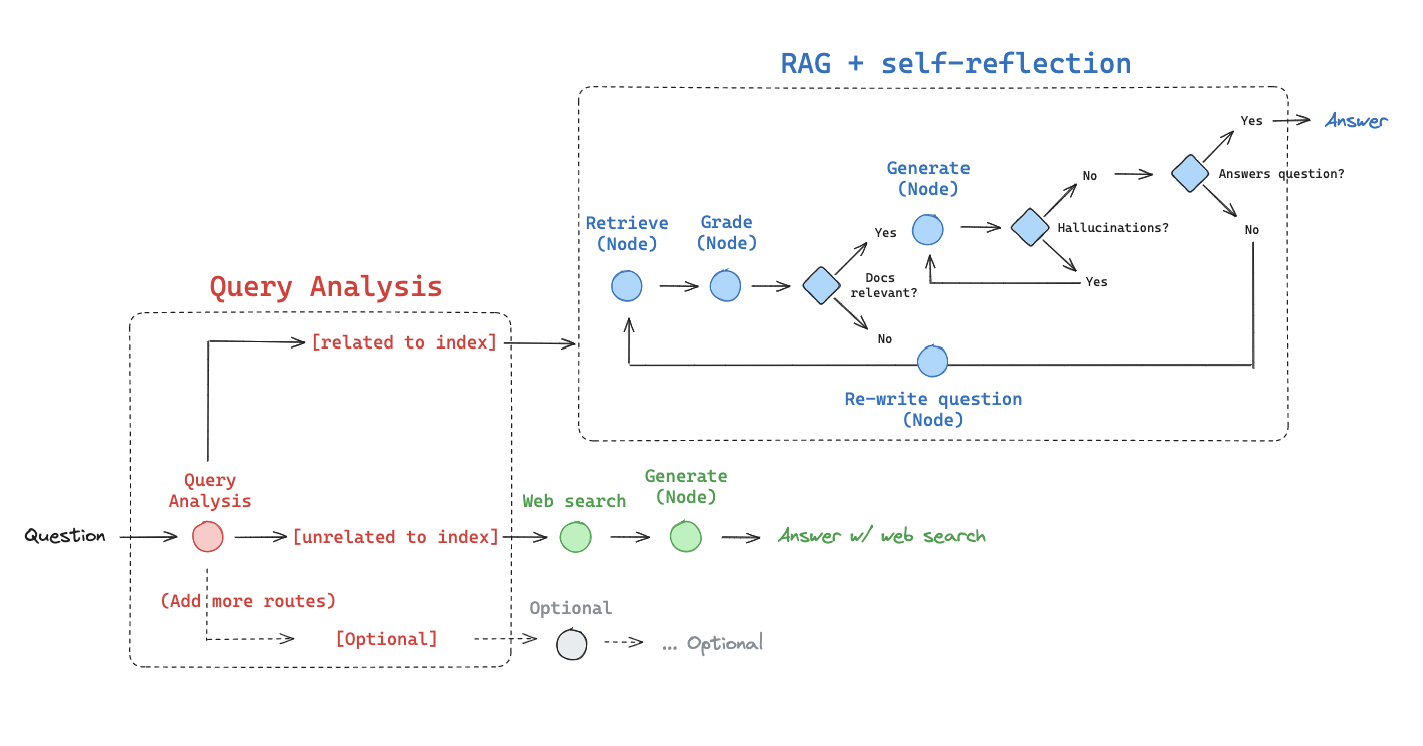

### Agentic RAG
Retreival analysis + Generation Analysis (Query rewriting)
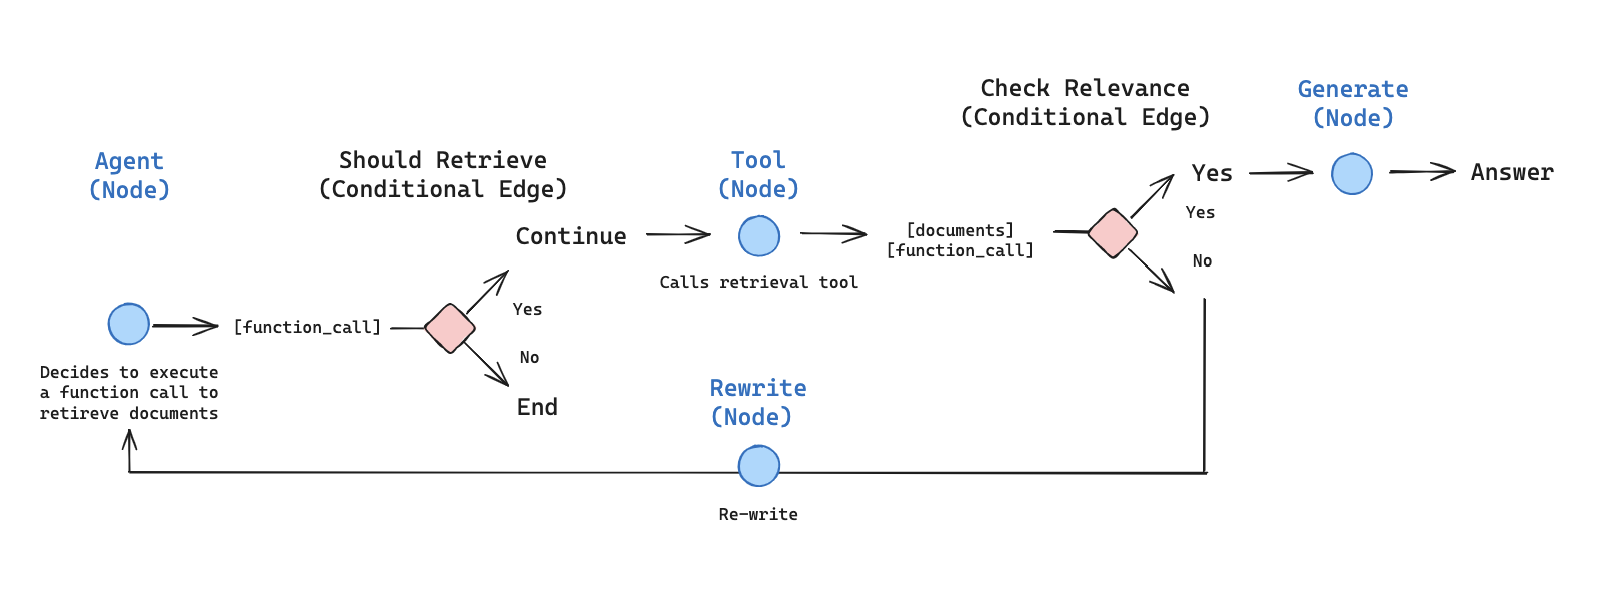

### Self RAG
Generation Analysis + Post Generation Analysis - Hallucination & Relevancy (Query rewriting)
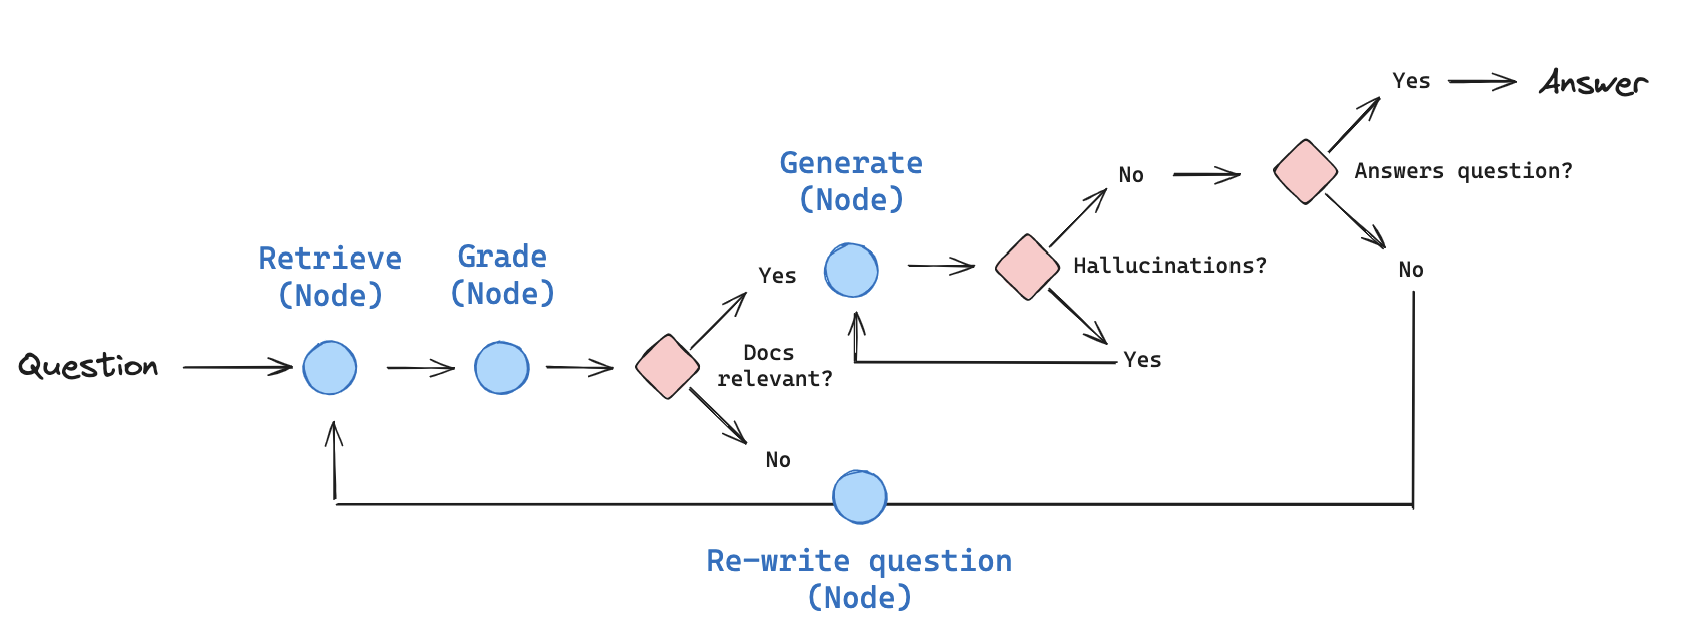

### Corrective RAG
Generation Analysis (Query rewriting + web search)
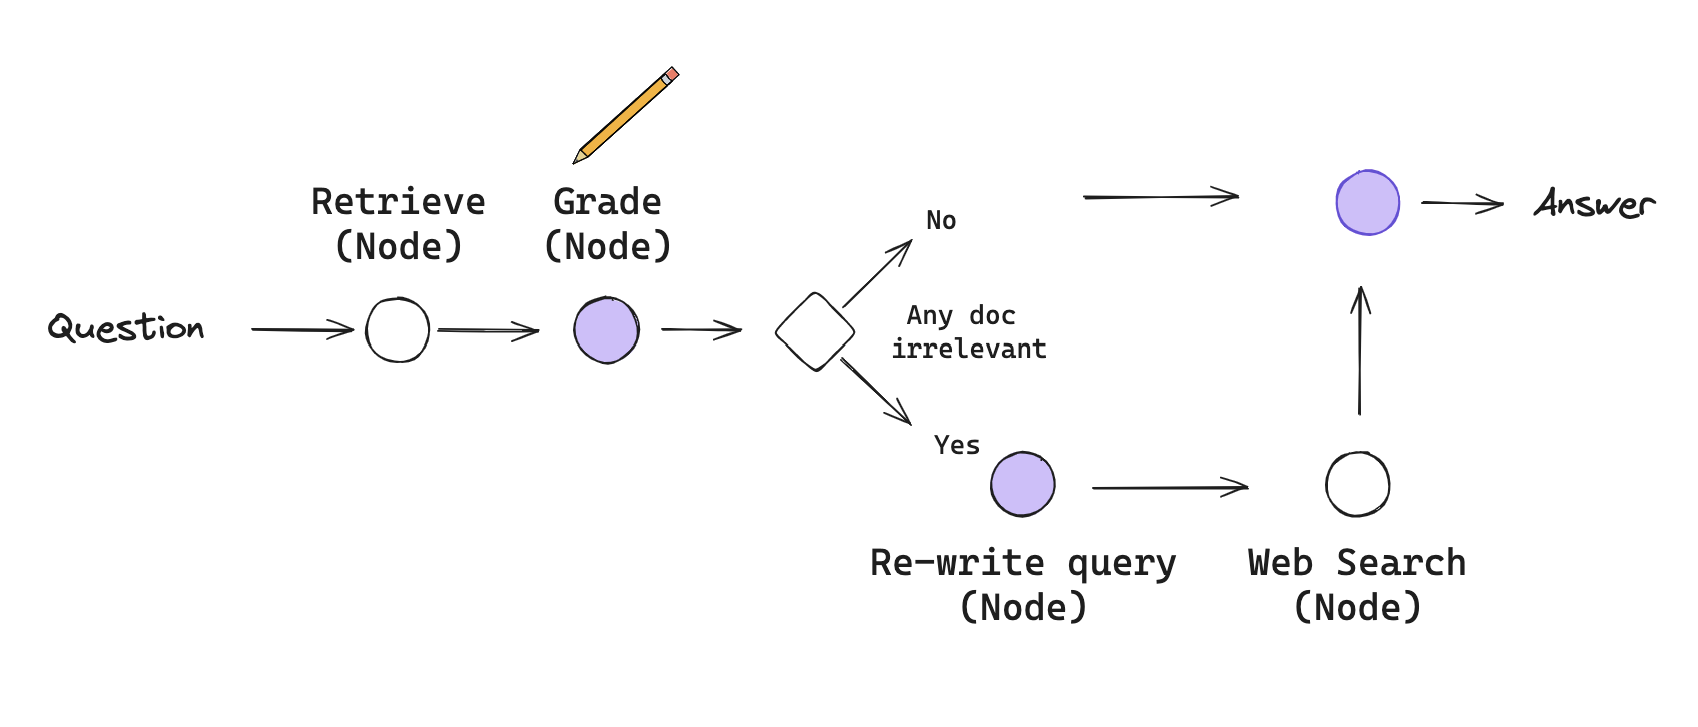

### loading the model

In [1]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

c:\Users\lalwa\Downloads\Learn_Agents\agents-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
result = llm.invoke("Write a ballad about LangChain")
print(result.content)

The coder toiled, both late and long,
With data streams, a tangled throng.
To weave them all, a task so grand,
A system built by human hand.

He'd wrestled with the APIs,
And struggled with the complexities,
Of prompt engineering, fine and keen,
A digital tapestry, unseen.

Then whispers came, upon the breeze,
Of LangChain, meant to bring him ease.
A framework new, a shining light,
To guide his code through darkest night.

(Chorus)
Oh, LangChain, LangChain, noble name,
You tame the chaos, quell the flame.
With chains of thought, you link and bind,
The scattered knowledge of mankind.

He learned of LLM's, powerful tools,
Their language models, breaking rules.
But how to guide, how to control,
Their vast potential, take its toll?

LangChain showed the path so clear,
With agents, chains, and memories near.
To build a system, strong and fast,
Whose knowledge base would ever last.

He built his prompts with careful hand,
And watched the system understand.
The chains he forged, both long and

### Let's Create a Retriever now

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()


USER_AGENT environment variable not set, consider setting it to identify your requests.


### Lets Create a RAG Chain Now

In [3]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

print(f"---PROMPT--- {prompt}")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

---PROMPT--- input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


### Let's test the RAG Chain Now

In [4]:
# Run
question = "tell me about agent memory."
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

LLM-powered autonomous agents utilize two types of memory: short-term memory, which leverages in-context learning within the model's limited context window, and long-term memory, which uses an external vector store for storing and retrieving information over extended periods.  This long-term memory often employs fast retrieval methods like approximate nearest neighbors algorithms.



### Now lets create grade document class

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

c:\Users\lalwa\Downloads\Learn_Agents\agents-env\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [7]:
question = "tell me about the agent memory."
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

C:\Users\lalwa\AppData\Local\Temp\ipykernel_7032\2925432907.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='yes'


In [ ]:
question = "tell me about the Tajmahal."
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### Let's Create Question Re-Writer

In [10]:
### Question Re-writer
# Prompt
from langchain_core.prompts import ChatPromptTemplate

system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
     
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [15]:
question_rewriter.invoke({"question": question})

'What is agent memory in artificial intelligence?\n'

### Lets create a required function

In [11]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
    
    """
    print("---RETRIEVE---")
    
    question = state["question"]
    
    documents = retriever.get_relevant_documents(question)
    
    return {"documents": documents, "question": question}

In [12]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    
    print("---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    
    web_search = "No"
    
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [13]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print("---GENERATE---")
    
    question = state["question"]
    documents = state["documents"]
    
    generation = rag_chain.invoke({"context": documents, "question": question})
    
    return {"documents": documents, "question": question, "generation": generation}

In [14]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    
    return {"documents": documents, "question": better_question}

### Web Crawling we gonna perform using Tavily

In [15]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [16]:

from langchain.schema import Document
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    
    web_results = "\n".join([d["content"] for d in docs])
    
    web_results = Document(page_content=web_results)
    
    documents.append(web_results)

    return {"documents": documents, "question": question}

In [17]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Let's create a skeleton of code then will create the function accordingly

In [18]:
from langgraph.graph import END, StateGraph, START

In [19]:
from typing import List

from typing_extensions import TypedDict

class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

workflow= StateGraph(State)

In [20]:
# define the nodes
# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

In [21]:
# Build graph
workflow.add_edge(START, "retrieve")

workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges("grade_documents", decide_to_generate, {"transform_query": "transform_query","generate": "generate",}),

workflow.add_edge("transform_query", "web_search_node")

workflow.add_edge("web_search_node", "generate")

workflow.add_edge("generate", END)

In [22]:
# Compile
app = workflow.compile()

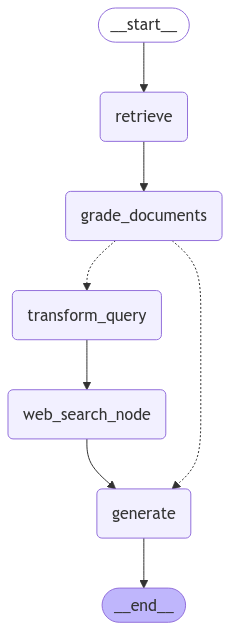

In [23]:
# Display the graph
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [24]:
from pprint import pprint

# Run
inputs = {"question": "tell me about the agent memory."}

In [31]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Agent memory includes short-term memory (in-context learning), and long-term '
 'memory (external vector store for information retrieval).  Sensory memory,  '
 'for raw inputs like text and images, is also a component.\n')


In [32]:
from pprint import pprint

# Run
inputs = {"question": "tell me about the taj mahal."}

In [33]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The Taj Mahal, commissioned in 1632 by Mughal emperor Shah Jahan, is a '
 'mausoleum for his wife Mumtaz Mahal.  Construction took 22 years and '
 'incorporated white marble inlaid with semi-precious stones.  Its '
 'significance lies in its architectural grandeur, symbolic representation of '
 'love and power, and status as a globally recognized symbol of India.\n')
